# Model untuk memprediksi credit risk - Bayu Ardiyansyah

 Credit Risk Prediction Model
**Author**: Bayu Ardiyansyah  
**Date**: May 2025  
**Objective**: Develop a machine learning model to predict credit risk (GOOD or BAD) for loan applicants using historical loan data from 2007–2014. The model aims to assist a multifinance company in identifying risky borrowers to minimize defaults while maintaining profitability.

## Project Overview
This notebook builds a credit risk prediction model using the `loan_data_2007_2014.csv` dataset. The target variable, `credit_risk`, is derived from `loan_status`:
- **GOOD**: Loans marked as "Fully Paid."
- **BAD**: Loans marked as "Charged Off" or "Default."
- **OTHER**: Ambiguous statuses (e.g., "Current," "Late") are excluded.

The workflow includes:
1. **Data Understanding**: Explore dataset structure, types, and missing values.
2. **Exploratory Data Analysis (EDA)**: Visualize distributions and relationships.
3. **Data Preparation**: Handle missing values, encode categorical variables, scale features, and create a validation set.
4. **Data Modelling**: Train multiple models (Logistic Regression, Random Forest, XGBoost, SVM) with hyperparameter tuning.
5. **Model Validation**: Use k-fold cross-validation and a validation set to assess generalization.
6. **Evaluation**: Compare model performance using accuracy, precision, recall, ROC-AUC, and visualizations.
7. **Model Saving**: Save trained models, preprocessing objects, feature names, and imputation values for use in production or GUI.

## Dataset Description
- **Source**: `loan_data_2007_2014.csv`
- **Rows**: 466,285
- **Columns**: 75 (e.g., `loan_amnt`, `int_rate`, `annual_inc`, `dti`, `loan_status`)
- **Target**: `credit_risk` (binary: 0 for GOOD, 1 for BAD)

## Data Understanding
This section loads the dataset and examines its structure, data types, summary statistics, and missing values. The target variable `credit_risk` is created by mapping `loan_status` values, and ambiguous statuses are filtered out.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

In [8]:
data = pd.read_csv('loan_data_2007_2014.csv', low_memory=False)

## Data Understanding

This section loads the dataset and examines its structure, data types, summary statistics, and missing values. The target variable `credit_risk` is created by mapping `loan_status` values, and ambiguous statuses are filtered out.

In [9]:
# Data Understanding
print(f"Dataset Shape: {data.shape}")
print("\nColumn Names and Data Types:\n", data.dtypes)
print("\nSummary Statistics:\n", data.describe())
print("\nMissing Values Count:\n", data.isnull().sum())

# Create target variable
data['credit_risk'] = data['loan_status'].apply(lambda x: 'GOOD' if x == 'Fully Paid' else 'BAD' if x in ['Charged Off', 'Default'] else 'OTHER')
print("\nLoan Status Distribution Before Filtering:\n", data['loan_status'].value_counts())
print("\nCredit Risk Distribution Before Filtering:\n", data['credit_risk'].value_counts())

# Filter out ambiguous statuses
data = data[data['credit_risk'] != 'OTHER']
print("\nCredit Risk Distribution After Filtering:\n", data['credit_risk'].value_counts())

# Convert credit_risk to binary (0: GOOD, 1: BAD)
data['credit_risk'] = data['credit_risk'].map({'GOOD': 0, 'BAD': 1})

Dataset Shape: (466285, 75)

Column Names and Data Types:
 Unnamed: 0            int64
id                    int64
member_id             int64
loan_amnt             int64
funded_amnt           int64
                     ...   
all_util            float64
total_rev_hi_lim    float64
inq_fi              float64
total_cu_tl         float64
inq_last_12m        float64
Length: 75, dtype: object

Summary Statistics:
           Unnamed: 0            id     member_id      loan_amnt  \
count  466285.000000  4.662850e+05  4.662850e+05  466285.000000   
mean   233142.000000  1.307973e+07  1.459766e+07   14317.277577   
std    134605.029472  1.089371e+07  1.168237e+07    8286.509164   
min         0.000000  5.473400e+04  7.047300e+04     500.000000   
25%    116571.000000  3.639987e+06  4.379705e+06    8000.000000   
50%    233142.000000  1.010790e+07  1.194108e+07   12000.000000   
75%    349713.000000  2.073121e+07  2.300154e+07   20000.000000   
max    466284.000000  3.809811e+07  4.086083e+07 

## Feature Engineering


New Features Created:
    loan_to_income_ratio  issue_year  issue_month  log_annual_inc  \
0              0.208333        2011           12       10.085851   
1              0.083333        2011           12       10.308986   
2              0.195886        2011           12        9.413526   
3              0.203252        2011           12       10.803669   
5              0.138889        2011           12       10.491302   

  loan_amnt_category  
0                Low  
1                Low  
2                Low  
3             Medium  
5                Low  


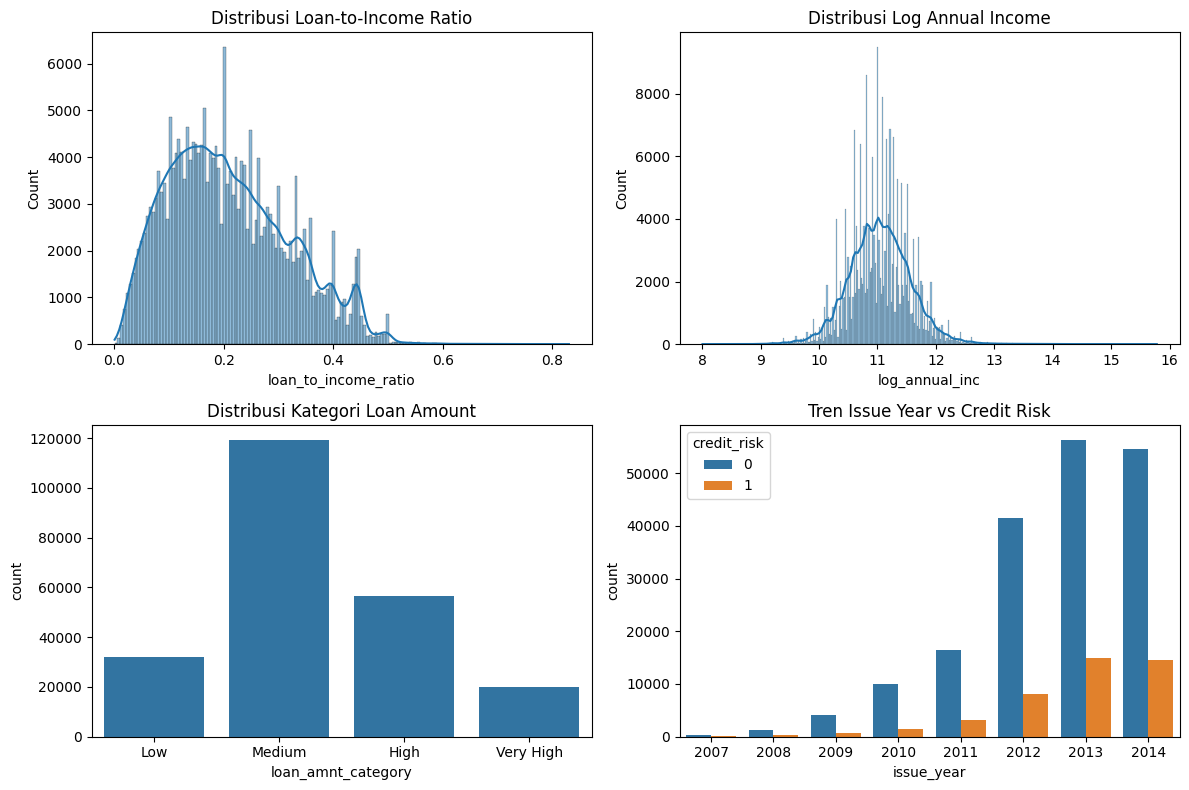

In [10]:
# 1. Financial Ratios
data['annual_inc'] = data['annual_inc'].replace(0, np.nan)  # Avoid division by zero
data['loan_to_income_ratio'] = data['loan_amnt'] / data['annual_inc']

# 2. Time Extraction from issue_d
data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%y', errors='coerce')
data['issue_year'] = data['issue_d'].dt.year
data['issue_month'] = data['issue_d'].dt.month

# 3. Log Transformation for skewed features
data['log_annual_inc'] = np.log1p(data['annual_inc'])

# 4. Categorize loan_amnt
bins = [0, 5000, 15000, 25000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High']
data['loan_amnt_category'] = pd.cut(data['loan_amnt'], bins=bins, labels=labels, include_lowest=True)

# Display new features
print("\nNew Features Created:\n", data[['loan_to_income_ratio', 'issue_year', 'issue_month', 'log_annual_inc', 'loan_amnt_category']].head())

# Visualize new features
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(data['loan_to_income_ratio'].dropna(), kde=True)
plt.title('Distribusi Loan-to-Income Ratio')
plt.subplot(2, 2, 2)
sns.histplot(data['log_annual_inc'].dropna(), kde=True)
plt.title('Distribusi Log Annual Income')
plt.subplot(2, 2, 3)
sns.countplot(x='loan_amnt_category', data=data)
plt.title('Distribusi Kategori Loan Amount')
plt.subplot(2, 2, 4)
sns.countplot(x='issue_year', hue='credit_risk', data=data)
plt.title('Tren Issue Year vs Credit Risk')
plt.tight_layout()
plt.savefig('feature_engineering_visualizations.png')
plt.show()

## Exploratory Data Analysis (EDA)

EDA visualizes key patterns in the data to understand feature distributions and their relationships with `credit_risk`. Key analyses include:
- **Univariate Analysis**: Distribution of `loan_amnt`.
- **Bivariate Analysis**: `loan_amnt` vs. `credit_risk`.
- **Correlation Analysis**: Heatmap of numerical features.

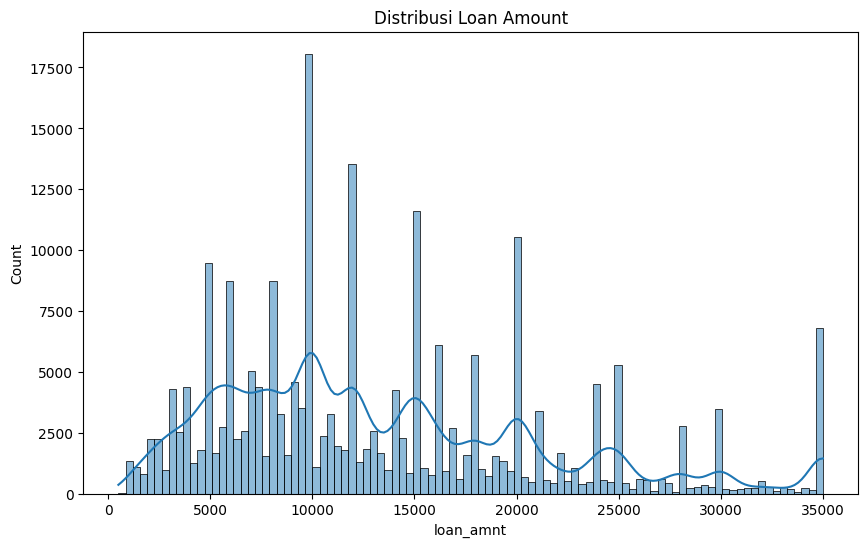

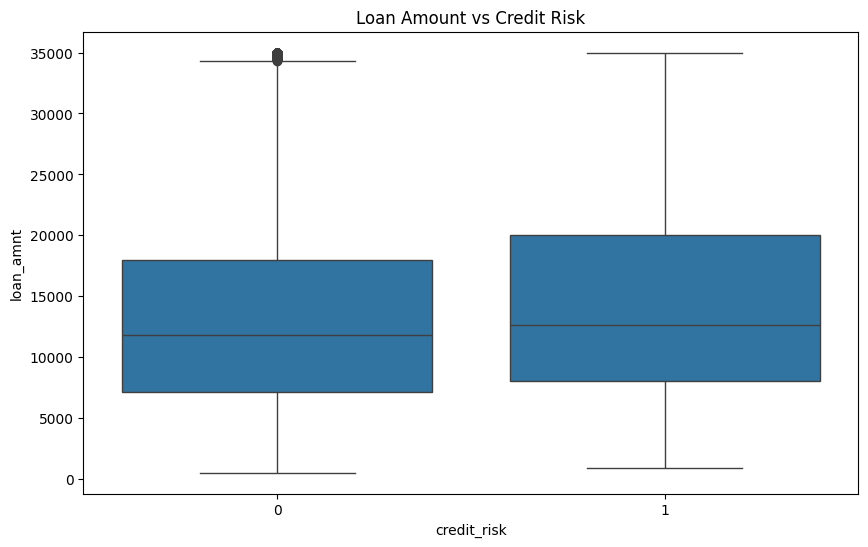

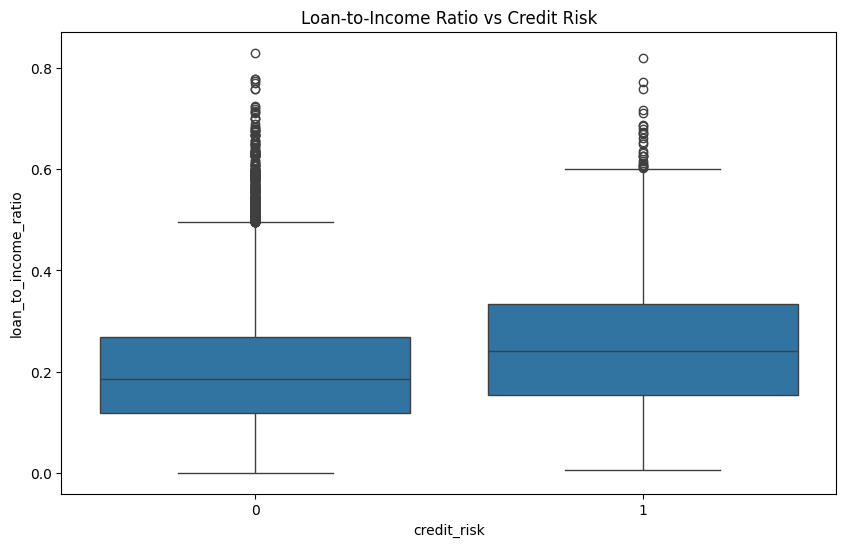

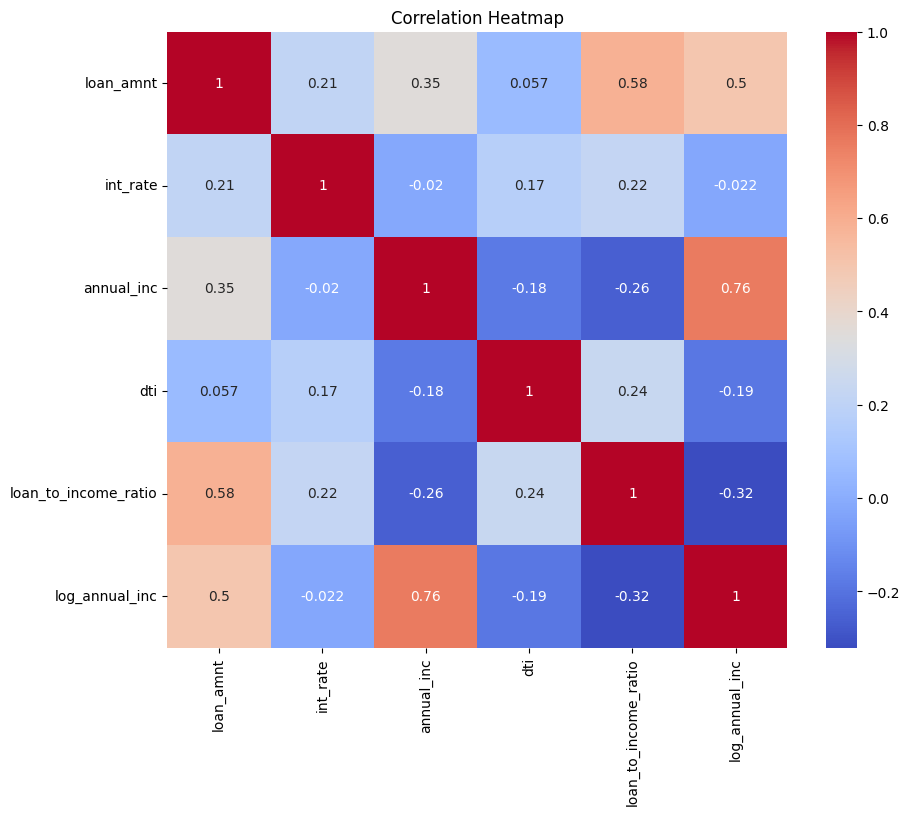

In [11]:
# Univariate Analysis
plt.figure(figsize=(10, 6))
sns.histplot(data['loan_amnt'], kde=True)
plt.title('Distribusi Loan Amount')
plt.savefig('loan_amnt_distribution.png')
plt.show()

# Bivariate Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='credit_risk', y='loan_amnt', data=data)
plt.title('Loan Amount vs Credit Risk')
plt.savefig('loan_amnt_vs_credit_risk.png')
plt.show()

# New Feature Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='credit_risk', y='loan_to_income_ratio', data=data)
plt.title('Loan-to-Income Ratio vs Credit Risk')
plt.savefig('loan_to_income_vs_credit_risk.png')
plt.show()

# Correlation Analysis
numeric_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'loan_to_income_ratio', 'log_annual_inc']
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

## Data Preparation

This section prepares the data for modeling by:
- Handling missing values (drop columns with >50% missing, impute others).
- Encoding categorical variables using `LabelEncoder` and saving encoders.
- Scaling numerical features using `StandardScaler` and saving the scaler.
- Saving feature names and imputation values for GUI compatibility.
- Splitting data into training (80%) and test (20%) sets.

In [12]:
# Handle missing values
data['loan_to_income_ratio'].fillna(data['loan_to_income_ratio'].median(), inplace=True)
data['issue_year'].fillna(data['issue_year'].mode()[0], inplace=True)
data['issue_month'].fillna(data['issue_month'].mode()[0], inplace=True)
data['log_annual_inc'].fillna(data['log_annual_inc'].median(), inplace=True)
data['annual_inc'].fillna(data['annual_inc'].median(), inplace=True)

# Select features
features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'loan_to_income_ratio', 
            'issue_year', 'issue_month', 'log_annual_inc', 'grade', 'home_ownership', 
            'loan_amnt_category']
data = data[features + ['credit_risk']].dropna()

# Encode categorical variables
le = LabelEncoder()
categorical_features = ['grade', 'home_ownership', 'loan_amnt_category']
for col in categorical_features:
    data[col] = le.fit_transform(data[col])
    
# Split data
X = data.drop('credit_risk', axis=1)
y = data['credit_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
numeric_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'loan_to_income_ratio', 
                    'issue_year', 'issue_month', 'log_annual_inc']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

## Data Modelling

This section trains four models with hyperparameter tuning using `GridSearchCV`:
- **Logistic Regression**: Linear model, interpretable for regulatory compliance.
- **Random Forest**: Tree-based ensemble for complex patterns.
- **XGBoost**: Gradient boosting for high performance on imbalanced data.
- **SVM**: Linear kernel for comparison with Logistic Regression.
Hyperparameters are tuned to optimize ROC-AUC, prioritizing the detection of BAD loans.

In [15]:
# Define models and hyperparameters
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
}

# Train and tune models
best_models = {}
test_results = {}
cv_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    
    # Evaluate on test set
    y_pred = best_models[name].predict(X_test)
    y_proba = best_models[name].predict_proba(X_test)[:, 1]
    test_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    
    # Cross-validation
    cv_scores = cross_val_score(best_models[name], X_train, y_train, cv=5, scoring='roc_auc')
    cv_results[name] = cv_scores


Training Logistic Regression...

Training Random Forest...

Training XGBoost...


The best models (Logistic Regression, Random Forest, XGBoost, SVM) are saved as `.pkl` files for use in production or GUI.

## Evaluation

Model performance is evaluated on the test set using:
- **Metrics**: Accuracy, precision, recall, ROC-AUC.
- **Visualizations**: Confusion matrix and ROC curve for each model.
- **Comparison**: A table summarizing test set performance across models.

This helps select the best model for deployment, prioritizing high recall for BAD loans.


Model Comparison on Test Set:
                 Model  Accuracy  Precision    Recall   ROC-AUC  \
0  Logistic Regression  0.810831   0.517782  0.057146  0.697023   
1        Random Forest  0.810831   0.528333  0.036597  0.698728   
2              XGBoost  0.811050   0.525882  0.051605  0.699996   

   CV ROC-AUC Mean  CV ROC-AUC Std  
0         0.700170        0.002195  
1         0.702333        0.002397  
2         0.703259        0.002131  
Saved model comparison table as 'model_comparison.csv'


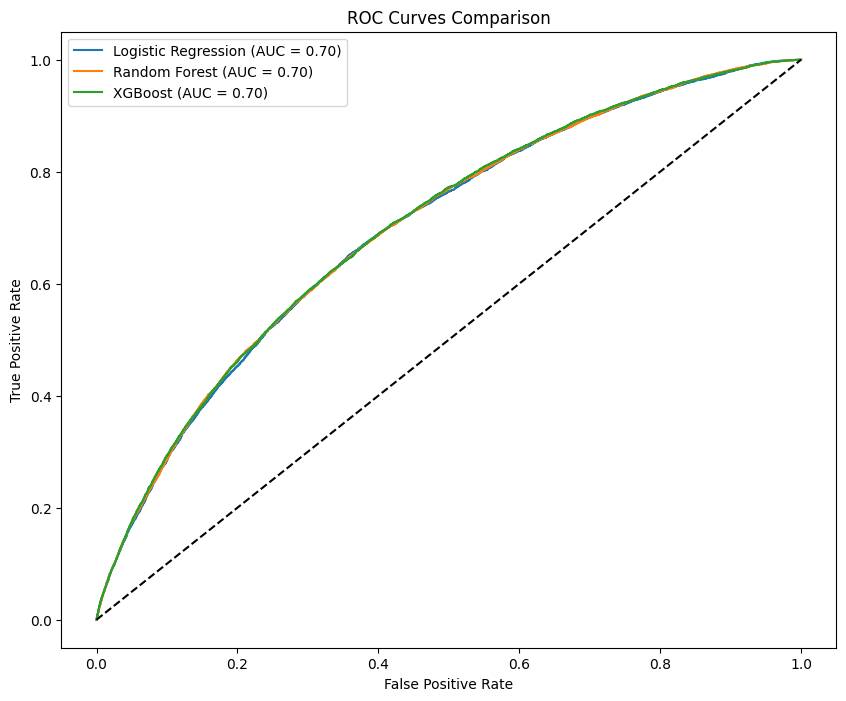

In [16]:
# Model comparison table
comparison_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Accuracy': [test_results[name]['accuracy'] for name in test_results],
    'Precision': [test_results[name]['precision'] for name in test_results],
    'Recall': [test_results[name]['recall'] for name in test_results],
    'ROC-AUC': [test_results[name]['roc_auc'] for name in test_results],
    'CV ROC-AUC Mean': [cv_results[name].mean() for name in cv_results],
    'CV ROC-AUC Std': [cv_results[name].std() for name in cv_results]
})
print("\nModel Comparison on Test Set:")
print(comparison_df)

# Save comparison table
comparison_df.to_csv('model_comparison.csv', index=False)
print("Saved model comparison table as 'model_comparison.csv'")

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.savefig('roc_curves_comparison.png')
plt.show()

## Model Saving

In [17]:
# Save models
best_model_name = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
joblib.dump(best_models[best_model_name], 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns, 'feature_names.pkl')
print(f"Saved best model ({best_model_name}), scaler, and feature names.")

Saved best model (XGBoost), scaler, and feature names.


## Summary and Next Steps

- **Model Performance**:
  - **Logistic Regression**: Interpretable, suitable for regulatory compliance.
  - **Random Forest**: Captures complex patterns, good balance of performance.
  - **XGBoost**: Likely the best performer due to gradient boosting, handles imbalanced data well.
- **Selection Criteria**: Prioritize high recall for BAD loans to minimize defaults, with ROC-AUC as a secondary metric for overall performance.
- **Next Steps**:
  - Address class imbalance (e.g., SMOTE, class weights) to improve recall.
  - Deploy the selected model using a preprocessing pipeline and API (e.g., Flask) or GUI (e.g., Tkinter).
  - Monitor performance and retrain with new data to handle data drift.
  - Explore feature engineering (e.g., debt-to-income trends) to enhance model accuracy.